In [1]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package libfuse2:amd64.
(Reading database ... 26397 files and directories currently installed.)
Preparing to unpack .../libfuse2_2.9.7-1ubuntu1_amd64.deb ...
Unpacking libfuse2:amd64 (2.9.7-1ubuntu1) ...
Selecting previously unselected package fuse.
Preparing to unpack .../fuse_2.9.7-1ubuntu1_amd64.deb ...
Unpacking fuse (2.9.7-1ubuntu1) ...
Selecting previously unselected package google-drive-ocamlfuse.
Preparing to unpack .../google-drive-ocamlfuse_0.7.1-0ubuntu2~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.1-0ubuntu2~ubuntu18.04.1) ...
Setting up libfuse2:amd64 (2.9.7-1ubuntu1) ...
Processing triggers for libc-bin (2.27-3ubuntu1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Setting up fuse (2.9.7-1ubuntu1) ...
Setting up google-drive-ocamlfuse (0.7.1-0ubuntu2~ubuntu18.04.1) ...
Please, open the following URL in a web browser: https://accounts.google

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [3]:
# importing librarys
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder,StandardScaler
from collections import Counter
from keras.layers import Convolution1D, Dense, Dropout, Flatten, MaxPooling1D,Activation,Embedding
from keras.models import Sequential
from keras import callbacks
from keras.layers import LSTM, GRU, SimpleRNN
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from keras.utils.np_utils import to_categorical

Using TensorFlow backend.


In [0]:
import tensorflow as tf

In [0]:
train_data = pd.read_csv('drive/merna_gamal_paper_cnn/kddtrain.csv')

In [6]:
train_data.head(10)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,Urgent,Hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.00,0.0,0.0,0.0,0.0,Normal
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.00,0.0,0.0,0.0,0.0,Normal
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.00,0.0,0.0,0.0,0.0,Normal
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.00,0.0,0.0,0.0,0.0,Normal
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.00,0.0,0.0,0.0,0.0,Normal
5,0,tcp,http,SF,217,2032,0,0,0,0,...,59,1.0,0.0,0.02,0.00,0.0,0.0,0.0,0.0,Normal
6,0,tcp,http,SF,212,1940,0,0,0,0,...,69,1.0,0.0,1.00,0.04,0.0,0.0,0.0,0.0,Normal
7,0,tcp,http,SF,159,4087,0,0,0,0,...,79,1.0,0.0,0.09,0.04,0.0,0.0,0.0,0.0,Normal
8,0,tcp,http,SF,210,151,0,0,0,0,...,89,1.0,0.0,0.12,0.04,0.0,0.0,0.0,0.0,Normal
9,0,tcp,http,SF,212,786,0,0,0,1,...,99,1.0,0.0,0.12,0.05,0.0,0.0,0.0,0.0,Normal


In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 494021 entries, 0 to 494020
Data columns (total 42 columns):
duration                       494021 non-null int64
protocol_type                  494021 non-null object
service                        494021 non-null object
flag                           494021 non-null object
src_bytes                      494021 non-null int64
dst_bytes                      494021 non-null int64
land                           494021 non-null int64
wrong_fragment                 494021 non-null int64
Urgent                         494021 non-null int64
Hot                            494021 non-null int64
num_failed_logins              494021 non-null int64
logged_in                      494021 non-null int64
num_compromised                494021 non-null int64
root_shell                     494021 non-null int64
su_attempted                   494021 non-null int64
num_root                       494021 non-null int64
num_file_creations             494021 

In [8]:
train_data.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,Urgent,Hot,num_failed_logins,logged_in,num_compromised,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,494021.000000,4.940210e+05,4.940210e+05,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,...,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000
mean,47.979302,3.025610e+03,8.685324e+02,0.000045,0.006433,0.000014,0.034519,0.000152,0.148247,0.010212,...,232.470778,188.665670,0.753780,0.030906,0.601935,0.006684,0.176754,0.176443,0.058118,0.057412
std,707.746472,9.882181e+05,3.304000e+04,0.006673,0.134805,0.005510,0.782103,0.015520,0.355345,1.798326,...,64.745380,106.040437,0.410781,0.109259,0.481309,0.042133,0.380593,0.380919,0.230590,0.230140
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,4.500000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,46.000000,0.410000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,5.200000e+02,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,255.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.032000e+03,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,255.000000,1.000000,0.040000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,58329.000000,6.933756e+08,5.155468e+06,1.000000,3.000000,3.000000,30.000000,5.000000,1.000000,884.000000,...,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [0]:
y_train = train_data.iloc[:]['class']
x_train = train_data.iloc[:,:-1]
np.set_printoptions(precision=3)


In [10]:
y_train.unique()

array(['Normal', 'U2R', 'DOS', 'R2L', 'PROBE'], dtype=object)

In [11]:
Counter(y_train)

Counter({'DOS': 391458,
         'Normal': 97278,
         'PROBE': 4107,
         'R2L': 1126,
         'U2R': 52})

In [0]:
x_train = pd.DataFrame({col: x_train[col].astype('category').cat.codes for col in x_train}, index=x_train.index)

In [13]:
x_train.tail()

,Hot,Urgent,count,diff_srv_rate,dst_bytes,dst_host_count,dst_host_diff_srv_rate,dst_host_rerror_rate,dst_host_same_src_port_rate,dst_host_same_srv_rate,...,same_srv_rate,serror_rate,service,src_bytes,srv_count,srv_diff_host_rate,srv_rerror_rate,srv_serror_rate,su_attempted,wrong_fragment
494016,0,0,4,0,1856,86,0,0,1,100,...,98,0,22,293,5,38,0,0,0,0
494017,0,0,6,0,2254,6,0,0,17,100,...,98,0,22,265,6,0,0,0,0,0
494018,0,0,6,0,1179,16,0,0,6,100,...,98,17,22,186,18,17,0,11,0,0
494019,0,0,6,0,1179,26,0,0,4,100,...,98,0,22,274,12,17,0,0,0,0
494020,0,0,6,0,1213,6,0,0,17,100,...,98,0,22,202,35,14,0,0,0,0


In [14]:
y_train.head()

0    Normal
1    Normal
2    Normal
3    Normal
4    Normal
Name: class, dtype: object

In [0]:
label_encoder = LabelEncoder()
fit = label_encoder.fit_transform(y_train)
y_train = pd.DataFrame( fit, index=y_train.index, columns=['class'] )

In [16]:
y_train.nunique() # from 0 to 4 --> 5 class

class    5
dtype: int64

In [17]:
y_train.head()

,class
0,1
1,1
2,1
3,1
4,1


In [0]:
scaler = StandardScaler()
scaler_data = scaler.fit_transform(x_train)

In [0]:
x_train = pd.DataFrame(data = scaler_data, index=x_train.index, columns=x_train.columns)

In [20]:
x_train.head()

,Hot,Urgent,count,diff_srv_rate,dst_bytes,dst_host_count,dst_host_diff_srv_rate,dst_host_rerror_rate,dst_host_same_src_port_rate,dst_host_same_srv_rate,...,same_srv_rate,serror_rate,service,src_bytes,srv_count,srv_diff_host_rate,srv_rerror_rate,srv_serror_rate,su_attempted,wrong_fragment
0,-0.049029,-0.002571,-1.536678,-0.290323,3.281686,-3.451536,-0.282867,-0.25204,-1.022077,0.599396,...,0.536878,-0.46419,-0.104067,-0.856640,-1.157402,-0.223401,-0.249632,-0.464053,-0.004676,-0.048834
1,-0.049029,-0.002571,-1.536678,-0.290323,0.079652,-3.297085,-0.282867,-0.25204,-1.146737,0.599396,...,0.536878,-0.46419,-0.104067,-0.741563,-1.157402,-0.223401,-0.249632,-0.464053,-0.004676,-0.048834
2,-0.049029,-0.002571,-1.536678,-0.290323,0.712180,-3.142633,-0.282867,-0.25204,-1.188291,0.599396,...,0.536878,-0.46419,-0.104067,-0.749499,-1.157402,-0.223401,-0.249632,-0.464053,-0.004676,-0.048834
3,-0.049029,-0.002571,-1.546537,-0.290323,0.712180,-2.988182,-0.282867,-0.25204,-1.188291,0.599396,...,0.536878,-0.46419,-0.104067,-0.781245,-1.166268,-0.223401,-0.249632,-0.464053,-0.004676,-0.048834
4,-0.049029,-0.002571,-1.546537,-0.290323,1.225040,-2.833731,-0.282867,-0.25204,-1.209067,0.599396,...,0.536878,-0.46419,-0.104067,-0.785213,-1.166268,-0.223401,-0.249632,-0.464053,-0.004676,-0.048834


In [0]:
train_x = np.reshape(scaler_data, (scaler_data.shape[0],1, scaler_data.shape[1]))
y_train1 = np.array(y_train)
y_train= to_categorical(y_train1)


In [22]:
y_train.shape

(494021, 5)

## now we are ready to make our model OOOLALA ready!! let's goooo

In [23]:

batch_size = 32

# 1. define the network
model = Sequential()
model.add(GRU(16,input_dim=41, return_sequences=True))  # try using a GRU instead, for fun
model.add(Dropout(0.1))
model.add(GRU(16, return_sequences=True))  # try using a GRU instead, for fun
model.add(Dropout(0.1))
model.add(GRU(16, return_sequences=False))  # try using a GRU instead, for fun
model.add(Dropout(0.1))
model.add(Dense(5))
model.add(Activation('softmax'))

print(model.summary())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `GRU` call to the Keras 2 API: `GRU(16, return_sequences=True, input_shape=(None, 41))`
  


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, None, 16)          2784      
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 16)          0         
_________________________________________________________________
gru_2 (GRU)                  (None, None, 16)          1584      
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 16)          0         
_________________________________________________________________
gru_3 (GRU)                  (None, 16)                1584      
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 85        
__________

In [0]:
model.compile(loss="categorical_crossentropy", optimizer="adam",metrics=['accuracy'])

In [0]:

# train
checkpointer = callbacks.ModelCheckpoint(filepath="checkpoint-{epoch:02d}.hdf5", verbose=1, save_best_only=True, monitor='val_acc',mode='max')
csv_logger = CSVLogger('cnntrainanalysis1.csv',separator=',', append=False)



In [27]:
model.fit(train_x, y_train, epochs=20,batch_size=batch_size, callbacks=[checkpointer,csv_logger])


Epoch 1/20
494021/494021 [==============================] - 80s 163us/step - loss: 0.0118 - acc: 0.9975
Epoch 2/20
   992/494021 [..............................] - ETA: 1:34 - loss: 0.0086 - acc: 0.9970

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:434: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


494021/494021 [==============================] - 80s 161us/step - loss: 0.0041 - acc: 0.9990
Epoch 3/20
494021/494021 [==============================] - 80s 163us/step - loss: 0.0034 - acc: 0.9991
Epoch 4/20
494021/494021 [==============================] - 80s 163us/step - loss: 0.0031 - acc: 0.9992
Epoch 5/20
494021/494021 [==============================] - 80s 161us/step - loss: 0.0029 - acc: 0.9992
Epoch 6/20
494021/494021 [==============================] - 79s 160us/step - loss: 0.0028 - acc: 0.9993
Epoch 7/20
494021/494021 [==============================] - 81s 164us/step - loss: 0.0026 - acc: 0.9994
Epoch 8/20
494021/494021 [==============================] - 82s 165us/step - loss: 0.0025 - acc: 0.9994
Epoch 9/20
494021/494021 [==============================] - 79s 161us/step - loss: 0.0025 - acc: 0.9993
Epoch 10/20
494021/494021 [==============================] - 80s 162us/step - loss: 0.0024 - acc: 0.9993
Epoch 11/20
494021/494021 [==============================] - 79s 161us/ste

In [0]:
model.save("drive/merna_gamal_paper_cnn/GRU/muiltyclass/cnn_model_2.hdf5")


In [0]:

test_data = pd.read_csv('drive/merna_gamal_paper_cnn/kddtest.csv')

In [30]:
test_data.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,Urgent,Hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,udp,private,SF,105,146,0,0,0,0,...,254,1.0,0.01,0.00,0.0,0.0,0.0,0.0,0.0,Normal
1,0,udp,private,SF,105,146,0,0,0,0,...,254,1.0,0.01,0.00,0.0,0.0,0.0,0.0,0.0,Normal
2,0,udp,private,SF,105,146,0,0,0,0,...,254,1.0,0.01,0.00,0.0,0.0,0.0,0.0,0.0,Normal
3,0,udp,private,SF,105,146,0,0,0,0,...,254,1.0,0.01,0.00,0.0,0.0,0.0,0.0,0.0,R2L
4,0,udp,private,SF,105,146,0,0,0,0,...,254,1.0,0.01,0.01,0.0,0.0,0.0,0.0,0.0,R2L


In [31]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 311029 entries, 0 to 311028
Data columns (total 42 columns):
duration                       311029 non-null int64
protocol_type                  311029 non-null object
service                        311029 non-null object
flag                           311029 non-null object
src_bytes                      311029 non-null int64
dst_bytes                      311029 non-null int64
land                           311029 non-null int64
wrong_fragment                 311029 non-null int64
Urgent                         311029 non-null int64
Hot                            311029 non-null int64
num_failed_logins              311029 non-null int64
logged_in                      311029 non-null int64
num_compromised                311029 non-null int64
root_shell                     311029 non-null int64
su_attempted                   311029 non-null int64
num_root                       311029 non-null int64
num_file_creations             311029 

In [32]:
test_data.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,Urgent,Hot,num_failed_logins,logged_in,num_compromised,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,311029.000000,3.110290e+05,3.110290e+05,311029.000000,311029.000000,311029.000000,311029.000000,311029.000000,311029.000000,311029.000000,...,311029.000000,311029.000000,311029.000000,311029.000000,311029.000000,311029.000000,311029.000000,311029.000000,311029.000000,311029.000000
mean,17.902736,1.731702e+03,7.479937e+02,0.000029,0.000762,0.000051,0.014677,0.002363,0.172476,0.011243,...,235.282681,199.193914,0.793494,0.024953,0.547919,0.004566,0.058764,0.058791,0.142659,0.141693
std,407.644400,1.276567e+05,1.612018e+04,0.005379,0.040367,0.009821,0.312068,0.049990,0.377794,1.958325,...,60.913298,100.306470,0.387090,0.096003,0.491963,0.035773,0.231296,0.232997,0.344380,0.346573
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.050000e+02,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,244.000000,0.970000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,5.200000e+02,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,255.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.032000e+03,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,255.000000,1.000000,0.010000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,57715.000000,6.282565e+07,5.203179e+06,1.000000,3.000000,3.000000,101.000000,4.000000,1.000000,796.000000,...,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [0]:
y_test = test_data.iloc[:]['class']
x_test = test_data.iloc[:,:-1]

In [34]:
y_test.unique()

array(['Normal', 'R2L', 'DOS', 'PROBE', 'U2R'], dtype=object)

In [35]:
Counter(y_test)

Counter({'DOS': 229853,
         'Normal': 60593,
         'PROBE': 4166,
         'R2L': 16347,
         'U2R': 70})

In [0]:
x_test = pd.DataFrame({col: x_test[col].astype('category').cat.codes for col in x_test}, index=x_test.index)

In [37]:
x_test.tail()

,Hot,Urgent,count,diff_srv_rate,dst_bytes,dst_host_count,dst_host_diff_srv_rate,dst_host_rerror_rate,dst_host_same_src_port_rate,dst_host_same_srv_rate,...,same_srv_rate,serror_rate,service,src_bytes,srv_count,srv_diff_host_rate,srv_rerror_rate,srv_serror_rate,su_attempted,wrong_fragment
311024,0,0,2,0,127,255,0,0,1,100,...,78,0,46,94,2,0,0,0,0,0
311025,0,0,4,0,127,255,0,0,1,100,...,78,0,46,94,4,0,0,0,0,0
311026,0,0,2,0,127,255,0,0,1,100,...,78,0,46,94,2,0,0,0,0,0
311027,0,0,4,0,127,255,0,0,1,100,...,78,0,46,94,4,0,0,0,0,0
311028,0,0,2,0,127,255,0,0,1,100,...,78,0,46,94,2,0,0,0,0,0


In [38]:
y_test.head()

0    Normal
1    Normal
2    Normal
3       R2L
4       R2L
Name: class, dtype: object

In [0]:
label_encoder = LabelEncoder()
fit = label_encoder.fit_transform(y_test)
y_test = pd.DataFrame( fit, index=y_test.index, columns=['class'] )

In [40]:
y_test.nunique() # from 0 to 4 --> 5 class

class    5
dtype: int64

In [41]:
y_test.head()

,class
0,1
1,1
2,1
3,3
4,3


In [0]:
scaler = StandardScaler()
scaler_data = scaler.fit_transform(x_test)

In [0]:
x_test = pd.DataFrame(data = scaler_data, index=x_test.index, columns=x_test.columns)

In [44]:
x_test.head()

,Hot,Urgent,count,diff_srv_rate,dst_bytes,dst_host_count,dst_host_diff_srv_rate,dst_host_rerror_rate,dst_host_same_src_port_rate,dst_host_same_srv_rate,...,same_srv_rate,serror_rate,service,src_bytes,srv_count,srv_diff_host_rate,srv_rerror_rate,srv_serror_rate,su_attempted,wrong_fragment
0,-0.064965,-0.005238,-1.226940,-0.229432,-0.189216,0.323695,-0.155751,-0.414249,-1.113742,0.533484,...,0.494943,-0.253519,1.428547,-0.917815,-0.990136,-0.209808,-0.408481,-0.252234,-0.003784,-0.020505
1,-0.064965,-0.005238,-1.226940,-0.229432,-0.189216,0.323695,-0.155751,-0.414249,-1.113742,0.533484,...,0.494943,-0.253519,1.428547,-0.917815,-0.990136,-0.209808,-0.408481,-0.252234,-0.003784,-0.020505
2,-0.064965,-0.005238,-1.226940,-0.229432,-0.189216,0.323695,-0.155751,-0.414249,-1.113742,0.533484,...,0.494943,-0.253519,1.428547,-0.917815,-0.990136,-0.209808,-0.408481,-0.252234,-0.003784,-0.020505
3,-0.064965,-0.005238,-1.222291,-0.229432,-0.189216,0.323695,-0.155751,-0.414249,-1.113742,0.533484,...,0.494943,-0.253519,1.428547,-0.917815,-0.985577,-0.209808,-0.408481,-0.252234,-0.003784,-0.020505
4,-0.064965,-0.005238,-1.222291,-0.229432,-0.189216,0.323695,-0.155751,-0.414249,-1.093415,0.533484,...,0.494943,-0.253519,1.428547,-0.917815,-0.985577,-0.209808,-0.408481,-0.252234,-0.003784,-0.020505


In [0]:
test_x = np.reshape(scaler_data, (scaler_data.shape[0],1,scaler_data.shape[1]))


In [0]:
y_test_arr = np.array(y_test)
y_test_cat = to_categorical(y_test_arr)

In [0]:
y_pred = model.predict_classes(test_x)

In [0]:
y_pred_df = pd.DataFrame(data=y_pred, columns=['class'])

In [49]:
y_pred_df.head()

,class
0,1
1,1
2,1
3,1
4,1


In [0]:
from sklearn.metrics import (precision_score, recall_score,f1_score, accuracy_score,mean_squared_error,mean_absolute_error)

In [51]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
loss, accuracy = model.evaluate(test_x, y_test_cat)


311029/311029 [==============================] - 11s 34us/step


In [52]:
print("\nLoss: %.2f, Accuracy: %.2f%%" % (loss, accuracy*100))


Loss: 1.04, Accuracy: 92.43%


In [53]:
print(y_test_arr.max())

4


In [54]:
recall = recall_score(y_test_arr, y_pred, average="micro")
recall


0.9243028785097209

In [55]:
precision = precision_score(y_test, y_pred , average="micro")
precision

0.9243028785097209

In [56]:
f1 = f1_score(y_test, y_pred, average="micro")
f1

0.9243028785097209

In [57]:
from sklearn import metrics

cm = metrics.confusion_matrix(y_test, y_pred)
cm

array([[223334,   5324,    311,    884,      0],
       [    97,  60188,    189,    114,      5],
       [   181,   1121,   2864,      0,      0],
       [     2,  15185,     69,   1091,      0],
       [     7,     45,      2,      8,      8]])

In [58]:
print("confusion matrix")
print("----------------------------------------------")
print("accuracy")
print("%.6f" %accuracy)
print("racall")
print("%.6f" %recall)
print("precision")
print("%.6f" %precision)
print("f1score")
print("%.6f" %f1)
cm = metrics.confusion_matrix(y_test_arr, y_pred)
print("==============================================")



confusion matrix
----------------------------------------------
accuracy
0.924303
racall
0.924303
precision
0.924303
f1score
0.924303


Confusion matrix, without normalization
[[223334   5324    311    884      0]
 [    97  60188    189    114      5]
 [   181   1121   2864      0      0]
 [     2  15185     69   1091      0]
 [     7     45      2      8      8]]
Normalized confusion matrix
[[9.72e-01 2.32e-02 1.35e-03 3.85e-03 0.00e+00]
 [1.60e-03 9.93e-01 3.12e-03 1.88e-03 8.25e-05]
 [4.34e-02 2.69e-01 6.87e-01 0.00e+00 0.00e+00]
 [1.22e-04 9.29e-01 4.22e-03 6.67e-02 0.00e+00]
 [1.00e-01 6.43e-01 2.86e-02 1.14e-01 1.14e-01]]


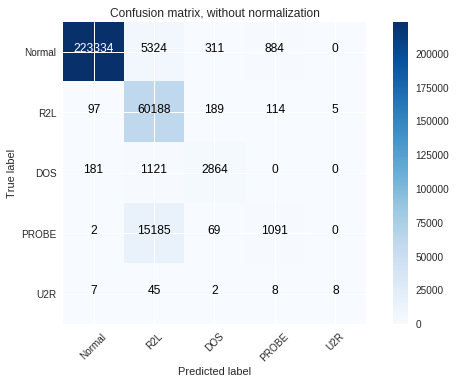

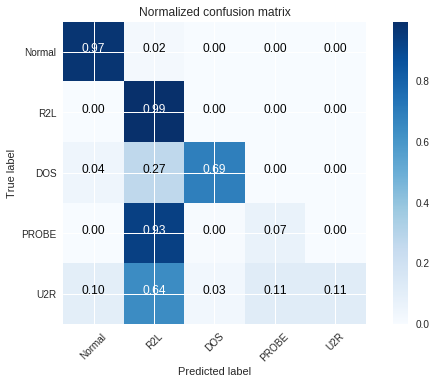

In [59]:
import matplotlib.pyplot as plt
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix =metrics.confusion_matrix(y_test_arr, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Normal', 'R2L', 'DOS', 'PROBE', 'U2R'], title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Normal', 'R2L', 'DOS', 'PROBE', 'U2R'], normalize=True,title='Normalized confusion matrix')

plt.show()

In [60]:
TruePositive = np.diag(cm)
TruePositive

array([223334,  60188,   2864,   1091,      8])

In [63]:
FalsePositive = []
for i in range(5):
    FalsePositive.append(sum(cm[:,i]) - cm[i,i])
FalsePositive

[287, 21675, 571, 1006, 5]

In [64]:
FalseNegative = []
for i in range(5):
    FalseNegative.append(sum(cm[i,:]) - cm[i,i])
FalseNegative

[6519, 405, 1302, 15256, 62]

In [65]:
TrueNegative = []
for i in range(5):
    temp = np.delete(cm, i, 0)   # delete ith row
    temp = np.delete(temp, i, 1)  # delete ith column
    TrueNegative.append(sum(sum(temp)))
TrueNegative

[80889, 228761, 306292, 293676, 310954]

In [66]:
num_classes=5
l = len(y_test)
for i in range(num_classes):
    print(TruePositive[i] + FalsePositive[i] + FalseNegative[i] + TrueNegative[i] == l)

True
True
True
True
True
